## Телеком — задача проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

## План модели предсказания ухода клиента

Необходимо начать с чтения файлов, содержащих данные, и проведения анализа общей информации. Это поможет понять, какие данные находятся в нашем распоряжении и какие шаги следует предпринять далее.

После этого следует обработка данных, включающая поиск пропущенных, nan значений и дубликатов. Также нужно заменить отсутствующие значения на медианы или на среднее значение, чтобы не искажать результаты. Наконец, следует объединить все полученные датафреймы.

Далее необходимо провести исследовательский анализ данных. Он включает построение графиков признаков и ухода клиентов, что поможет понять зависимости между различными переменными и выявить потенциально важные факторы.

После этого следует предварительная обработка данных для обучения моделей. Это включает создание численных признаков и производных признаков на основе уже имеющихся. Такие признаки могут помочь улучшить результаты предсказаний.

Далее следует построение моделей. В этом шаге мы подбираем гиперпараметры и выбираем наилучшую модель, используя уже обработанные данные. Это поможет получить наиболее точные предсказания.

Наконец, необходимо произвести вывод результатов на основе модели, которую мы получили на предыдущем шаге. Это может включать в себя описание ключевых факторов, влияющих на нашу модель, а также обсуждение ее эффективности и ограничений.

## Загружаем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
import re

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score

from sklearn.metrics import classification_report

RANDOM_STATE = 100423

### EDA

In [2]:
def eda_contract_data(df):
    '''
    Выполняет исследовательский анализ данных для договорных данных.

    Параметры:
    df (pandas.DataFrame): договорные данные в виде объекта pandas DataFrame.

    Возвращает:
    None.
    '''
    # Вывод первых 5 строк
    print('Первые 5 строк:')
    print(df.head())

    # Проверка типов данных и пропущенных значений
    print('\nИнформация о данных:')
    print(df.info())

    # Проверка на дубликаты
    print('\nДубликаты:')
    print('Количество дубликатов (все столбцы): {:.0f}'.format(df.duplicated().sum()))
    print('Количество дубликатов (только идентификаторы): {:.0f}'.format(df.duplicated(subset=['customerID']).sum()))

    # Вывод названий столбцов
    print('\nНазвания столбцов:')
    print(df.columns)

In [3]:
try:
    contract = pd.read_csv('contract_new.csv')
except FileNotFoundError:
    try:
        contract = pd.read_csv('/datasets/contract_new.csv')
    except FileNotFoundError:
        print('Contract file not found!')

try:
    internet = pd.read_csv('internet_new.csv')
except FileNotFoundError:
    try:
        internet = pd.read_csv('/datasets/internet_new.csv')
    except FileNotFoundError:
        print('Internet file not found!')

try:
    personal = pd.read_csv('personal_new.csv')
except FileNotFoundError:
    try:
        personal = pd.read_csv('/datasets/personal_new.csv')
    except FileNotFoundError:
        print('Personal file not found!')

try:
    phone = pd.read_csv('phone_new.csv')
except FileNotFoundError:
    try:
        phone = pd.read_csv('/datasets/phone_new.csv')
    except FileNotFoundError:
        print('Phone file not found!')

In [4]:
eda_contract_data(contract)

Первые 5 строк:
   customerID   BeginDate EndDate            Type PaperlessBilling  \
0  7590-VHVEG  2020-01-01      No  Month-to-month              Yes   
1  5575-GNVDE  2017-04-01      No        One year               No   
2  3668-QPYBK  2019-10-01      No  Month-to-month              Yes   
3  7795-CFOCW  2016-05-01      No        One year               No   
4  9237-HQITU  2019-09-01      No  Month-to-month              Yes   

               PaymentMethod  MonthlyCharges TotalCharges  
0           Electronic check           29.85        31.04  
1               Mailed check           56.95      2071.84  
2               Mailed check           53.85       226.17  
3  Bank transfer (automatic)           42.30       1960.6  
4           Electronic check           70.70        353.5  

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            -----

Всего в таблице 7043 записи. Все столбцы, кроме MonthlyCharges, имеют тип данных object. Столбец TotalCharges также должен иметь тип float64, однако в нем присутствуют некоторые нечисловые значения, что приводит к тому, что весь столбец имеет тип object.

Дубликатов нет.

In [5]:
eda_contract_data(internet)

Первые 5 строк:
   customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0  7590-VHVEG             DSL             No          Yes               No   
1  5575-GNVDE             DSL            Yes           No              Yes   
2  3668-QPYBK             DSL            Yes          Yes               No   
3  7795-CFOCW             DSL            Yes           No              Yes   
4  9237-HQITU     Fiber optic             No           No               No   

  TechSupport StreamingTV StreamingMovies  
0          No          No              No  
1          No          No              No  
2          No          No              No  
3         Yes          No              No  
4          No          No              No  

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non

Дубликатов и пропущенных значений нет. Все столбцы имеют тип object.

In [6]:
eda_contract_data(personal)

Первые 5 строк:
   customerID  gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0     Yes         No
1  5575-GNVDE    Male              0      No         No
2  3668-QPYBK    Male              0      No         No
3  7795-CFOCW    Male              0      No         No
4  9237-HQITU  Female              0      No         No

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None

Дубликаты:
Количество дубликатов (все столбцы): 0
Количество дубликатов (только идентификаторы): 0

Названия столбцов:
Index(['customerID', 'gender', 'SeniorCiti

Датасет содержит 7043 строк и 5 столбцов: пол клиента ('gender'), возраст ('SeniorCitizen'), наличие партнера ('Partner') и иждивенцев ('Dependents'). Пропущенные значения отсутствуют, дубликаты тоже.

In [7]:
eda_contract_data(phone)

Первые 5 строк:
   customerID MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No
2  9237-HQITU            No
3  9305-CDSKC           Yes
4  1452-KIOVK           Yes

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None

Дубликаты:
Количество дубликатов (все столбцы): 0
Количество дубликатов (только идентификаторы): 0

Названия столбцов:
Index(['customerID', 'MultipleLines'], dtype='object')









Всего имеется 6361 запись. Пропущенных значений нет. Тип данных в столбцах - object. Дубликаты отсутствуют.

### Этап "type of data"

In [8]:
# Изменение типа данных и извлечение года и месяца
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'])
contract['Begin_year'] = contract['BeginDate'].dt.year
contract['Begin_month'] = contract['BeginDate'].dt.month
today = '2020-02-01'


In [9]:
# Расчет продолжительности контракта в днях и создание нового столбца 'Contract_period'
# Фильтруем строки, где дата окончания контракта не равна 'No' и выбираем столбец с датами окончания контракта
contract['Contract_period'] = contract.query('EndDate != "No"')['EndDate']

#Заполняем пропущенные значения даты окончания контракта текущей датой
contract['Contract_period'] = contract['Contract_period'].fillna(today)

#Преобразуем столбец с датами окончания контракта в формат datetime
contract['Contract_period'] = pd.to_datetime(contract['Contract_period'], format='%Y-%m-%d %H:%M:%S')

#Рассчитываем продолжительность контракта в днях
contract['Contract_period'] = (contract['Contract_period'] - contract['BeginDate']).dt.days

In [10]:
# Создание столбца 'Valid_client', указывающего, действителен ли контракт на текущую дату
contract['NOT_Valid_client'] = [1 if x==False else 0 for x in contract['EndDate'] == "No"]

In [11]:
# Удаление столбцов 'EndDate' и 'BeginDate'
contract.drop(['EndDate', 'BeginDate'], axis=1, inplace=True)

In [12]:
# Перевод столбца 'TotalCharges' в тип данных 'float' и удаление строк с пропущенными значениями
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')
contract.dropna(subset=['TotalCharges'], inplace=True)
print(contract['TotalCharges'].dtypes)

float64


In [13]:
# Объединим таблицы по заданному столбцу
df = (contract
      .merge(internet, on='customerID', how='left')
      .merge(personal, on='customerID', how='left')
      .merge(phone, on='customerID', how='left'))


In [14]:
df

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Begin_year,Begin_month,Contract_period,NOT_Valid_client,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,2020,1,31,0,...,Yes,No,No,No,No,Female,0,Yes,No,NaN
1,5575-GNVDE,One year,No,Mailed check,56.95,2071.84,2017,4,1036,0,...,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,2019,10,123,0,...,Yes,No,No,No,No,Male,0,No,No,No
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,2016,5,1371,0,...,No,Yes,Yes,No,No,Male,0,No,No,NaN
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,2019,9,153,0,...,No,No,No,No,No,Female,0,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,6840-RESVB,One year,Yes,Mailed check,84.80,2035.20,2018,2,730,0,...,No,Yes,Yes,Yes,Yes,Male,0,Yes,Yes,Yes
7028,2234-XADUH,One year,Yes,Credit card (automatic),103.20,7430.40,2014,2,2191,0,...,Yes,Yes,No,Yes,Yes,Female,0,Yes,Yes,Yes
7029,4801-JZAZL,Month-to-month,Yes,Electronic check,29.60,325.60,2019,3,337,0,...,No,No,No,No,No,Female,0,Yes,Yes,NaN
7030,8361-LTMKD,Month-to-month,Yes,Mailed check,74.40,520.80,2019,7,215,0,...,No,No,No,No,No,Male,1,Yes,No,Yes


In [15]:
eda_contract_data(df)

Первые 5 строк:
   customerID            Type PaperlessBilling              PaymentMethod  \
0  7590-VHVEG  Month-to-month              Yes           Electronic check   
1  5575-GNVDE        One year               No               Mailed check   
2  3668-QPYBK  Month-to-month              Yes               Mailed check   
3  7795-CFOCW        One year               No  Bank transfer (automatic)   
4  9237-HQITU  Month-to-month              Yes           Electronic check   

   MonthlyCharges  TotalCharges  Begin_year  Begin_month  Contract_period  \
0           29.85         31.04        2020            1               31   
1           56.95       2071.84        2017            4             1036   
2           53.85        226.17        2019           10              123   
3           42.30       1960.60        2016            5             1371   
4           70.70        353.50        2019            9              153   

   NOT_Valid_client  ... OnlineBackup DeviceProtection Tec

Всего в датасете 7032 записи. Нет дубликатов. В некоторых столбцах есть пропущенные значения.     
Пропущенные значения в столбцах "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "MultipleLines" могли возникнуть по разным причинам. Например, клиент мог не выбирать некоторые опции при подписке на услуги, данные могут быть утеряны в процессе обработки, или могут быть недоступны из-за технических проблем. Кроме того, эти услуги могут быть не предоставлены в определенных районах, что может привести к отсутствию данных для некоторых клиентов. В любом случае, необходимо более детальное исследование данных и общение с провайдером, чтобы установить причину пропущенных значений.

# OHE

In [16]:
features = df.drop(columns=['customerID', 'NOT_Valid_client', 'Begin_year', 'Begin_month'])
target = df['NOT_Valid_client']

In [17]:
features_train, features_test, target_train, target_test = train_test_split(
                features, target, test_size=0.25, random_state=RANDOM_STATE, stratify=target)

In [18]:
# Просмотр возможных значений признаков 'Type', 'PaperlessBilling' и 'PaymentMethod'
print(df['Type'].unique())
print(df['PaperlessBilling'].unique())
print(df['PaymentMethod'].unique())

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder




ohe_features = features_train.select_dtypes(include='object').columns.to_list()
ohe_features.append('SeniorCitizen')
num_features = features_train.select_dtypes(exclude='object').columns.to_list()
num_features.remove('SeniorCitizen')
print(ohe_features)
print(num_features)
features_train_encoded = pd.get_dummies(features_train, columns = ohe_features, drop_first = True)
display(features_train_encoded)
features_test_encoded = pd.get_dummies(features_test, columns = ohe_features, drop_first = True)
display(features_test_encoded)
train_cols = set(features_train_encoded.columns)
test_cols = set(features_test_encoded.columns)
if train_cols.difference(test_cols) or test_cols.difference(train_cols):
    print("Колонки в train и test не совпадают")
else:
    print("Колонки в train и test совпадают")

['Month-to-month' 'One year' 'Two year']
['Yes' 'No']
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
['Type', 'PaperlessBilling', 'PaymentMethod', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'gender', 'Partner', 'Dependents', 'MultipleLines', 'SeniorCitizen']
['MonthlyCharges', 'TotalCharges', 'Contract_period']


,MonthlyCharges,TotalCharges,Contract_period,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic,...,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,gender_Male,Partner_Yes,Dependents_Yes,MultipleLines_Yes,SeniorCitizen_1
4583,21.20,216.24,306,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5379,19.90,39.80,62,0,0,0,0,0,1,0,...,0,0,0,0,0,1,1,1,0,0
4609,20.70,41.40,62,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3658,50.80,203.20,123,0,0,1,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0
6483,19.75,483.48,730,0,1,0,0,0,1,0,...,0,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6589,74.30,4235.10,1737,0,1,1,1,0,0,0,...,1,1,1,1,0,0,0,0,0,0
772,95.80,3257.20,1036,1,0,1,0,1,0,1,...,0,1,0,1,1,1,1,0,0,0
2377,39.50,1179.87,883,1,0,0,1,0,0,0,...,1,0,1,0,0,0,0,0,0,0
3102,113.65,6500.78,1673,0,1,1,0,0,0,1,...,1,1,1,1,1,0,1,0,1,0


,MonthlyCharges,TotalCharges,Contract_period,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic,...,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,gender_Male,Partner_Yes,Dependents_Yes,MultipleLines_Yes,SeniorCitizen_1
5764,60.55,2331.18,1067,0,0,0,0,1,0,0,...,1,1,0,0,0,0,0,0,0,0
6751,55.00,2145.00,1187,0,0,0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0
3535,40.65,2191.03,1492,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
2786,74.35,4492.23,1737,0,1,1,0,0,0,0,...,0,1,0,1,1,1,0,0,0,0
4598,25.00,275.00,337,0,1,0,0,0,1,0,...,0,0,0,0,0,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6533,76.00,1530.64,580,0,0,1,0,0,1,1,...,0,0,0,0,0,1,0,0,1,0
2779,98.10,490.50,153,0,0,1,0,0,0,1,...,0,1,1,1,1,0,0,1,0,0
1829,45.10,90.20,62,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1
3738,75.50,2041.52,792,1,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0


Колонки в train и test совпадают


In [20]:
# Просмотр возможных значений признаков 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV' и 'StreamingMovies'
print('InternetService:', df['InternetService'].unique())
print('OnlineSecurity:', df['OnlineSecurity'].unique())
print('OnlineBackup:', df['OnlineBackup'].unique())
print('DeviceProtection:', df['DeviceProtection'].unique())
print('TechSupport:', df['TechSupport'].unique())
print('StreamingTV:', df['StreamingTV'].unique())
print('StreamingMovies:', df['StreamingMovies'].unique())


InternetService: ['DSL' 'Fiber optic' nan]
OnlineSecurity: ['No' 'Yes' nan]
OnlineBackup: ['Yes' 'No' nan]
DeviceProtection: ['No' 'Yes' nan]
TechSupport: ['No' 'Yes' nan]
StreamingTV: ['No' 'Yes' nan]
StreamingMovies: ['No' 'Yes' nan]


In [21]:
# Проверяем, содержит ли столбец 'InternetService' только 2 уникальных значения
print('MultipleLines:', df['MultipleLines'].unique())

# Преобразуем столбец 'MultipleLines' 
df = pd.get_dummies(
    df,
    columns=['MultipleLines'],
    dummy_na=True,
    drop_first=True
)

MultipleLines: [nan 'No' 'Yes']


In [22]:
eda_contract_data(df)

Первые 5 строк:
   customerID            Type PaperlessBilling              PaymentMethod  \
0  7590-VHVEG  Month-to-month              Yes           Electronic check   
1  5575-GNVDE        One year               No               Mailed check   
2  3668-QPYBK  Month-to-month              Yes               Mailed check   
3  7795-CFOCW        One year               No  Bank transfer (automatic)   
4  9237-HQITU  Month-to-month              Yes           Electronic check   

   MonthlyCharges  TotalCharges  Begin_year  Begin_month  Contract_period  \
0           29.85         31.04        2020            1               31   
1           56.95       2071.84        2017            4             1036   
2           53.85        226.17        2019           10              123   
3           42.30       1960.60        2016            5             1371   
4           70.70        353.50        2019            9              153   

   NOT_Valid_client  ... DeviceProtection TechSupport Stre

Данные содержат информацию о клиентах компании телекоммуникаций. Всего в датасете 7032 записи и 26 столбцов.  Все столбцы имеют правильные типы данных.

In [23]:
print(df.columns)

Index(['customerID', 'Type', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Begin_year', 'Begin_month',
       'Contract_period', 'NOT_Valid_client', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'gender', 'SeniorCitizen', 'Partner',
       'Dependents', 'MultipleLines_Yes', 'MultipleLines_nan'],
      dtype='object')


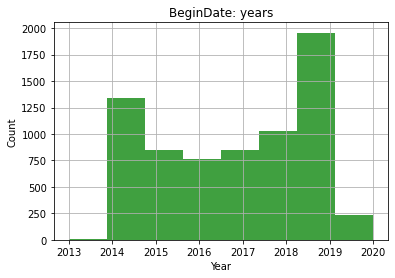

In [24]:
plt.hist(contract['Begin_year'], 8, facecolor='green', alpha=0.75)

plt.xlabel('Year')
plt.ylabel('Count')
plt.title('BeginDate: years')
plt.grid(True)

Можно заметить, что в 2020 году количество новых контрактов значительно уменьшилось, что может быть связано с пандемией COVID-19 и изменением потребительского поведения. На графике видно, что количество контрактов росло каждый год с 2014 года, и достигло пика в 2019 году. Это может объясняться увеличением числа людей, использующих услуги интернета и телевидения, что может быть связано с развитием технологий и увеличением числа доступных сервисов и провайдеров в регионе. Кроме того, могут быть и другие факторы, такие как увеличение населения или экономический рост, что может увеличить количество людей, которые могут себе позволить платить за подобные услуги.

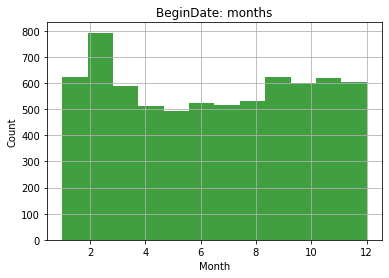

In [25]:
plt.hist(contract['Begin_month'], 12, facecolor='green', alpha=0.75)

plt.xlabel('Month')
plt.ylabel('Count')
plt.title('BeginDate: months')
plt.grid(True)

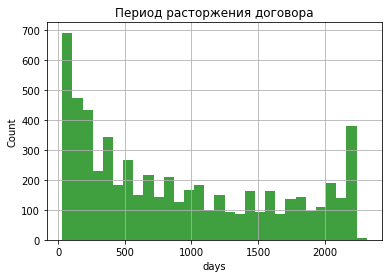

In [26]:
plt.hist(df[df['NOT_Valid_client'] == 0]['Contract_period'], 30, facecolor='green', alpha=0.75)

plt.xlabel('days')
plt.ylabel('Count')
plt.title('Период расторжения договора')
plt.grid(True)

Данный график показывает распределение периода расторжения договоров среди клиентов, которые расторгают договор. Мы видим, что большинство клиентов выбирают контракты на один или два года. Также можно заметить, что имеются некоторые выбросы в виде контрактов на более длительный период, до 5 лет.

Такой график может быть полезен для анализа предпочтений клиентов при выборе периода контракта и может помочь компании определить оптимальную стратегию ценообразования и продолжительности контрактов.

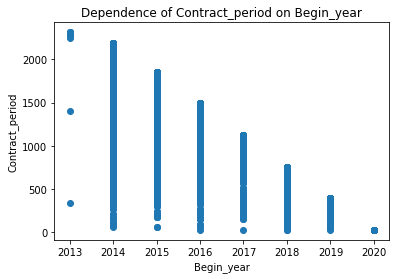

In [27]:
# График зависимости между Begin_year и Contract_period
plt.scatter(df['Begin_year'], df['Contract_period'])
plt.xlabel('Begin_year')
plt.ylabel('Contract_period')
plt.title('Dependence of Contract_period on Begin_year')
plt.show()


Этот график показывает зависимость между годом начала пользования услугами компании и длительностью контракта.

На графике можно заметить, что клиенты, начавшие пользоваться услугами компании в более поздние годы, склонны выбирать более короткие контракты. Например, клиенты, начавшие пользоваться услугами компании в 2017 году, чаще всего выбирают контракты на 1 год, тогда как клиенты, начавшие пользоваться услугами компании в 2014 году, чаще выбирают контракты на 2 года.

Это может свидетельствовать о том, что компания меняет свою стратегию продаж с течением времени, и сейчас склонна предлагать более короткие контракты. Это также может быть связано с тем, что клиенты чаще смотрят на короткий срок контракта, так как это дает им большую гибкость в выборе провайдера услуг.

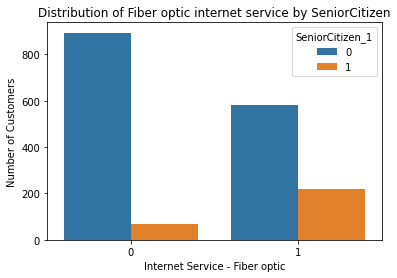

In [28]:
sns.countplot(x='InternetService_Fiber optic', hue='SeniorCitizen_1', data=features_test_encoded)
plt.xlabel('Internet Service - Fiber optic')
plt.ylabel('Number of Customers')
plt.title('Distribution of Fiber optic internet service by SeniorCitizen')
plt.show()


На этом графике мы видим, как количество клиентов, выбравших услугу "Fiber optic" в зависимости от возраста. Количество молодых клиентов, выбравших данную услугу, значительно превышает количество старших граждан. Причем, старшие граждане значительно реже выбирают данную услугу.

<AxesSubplot:xlabel='Type', ylabel='count'>

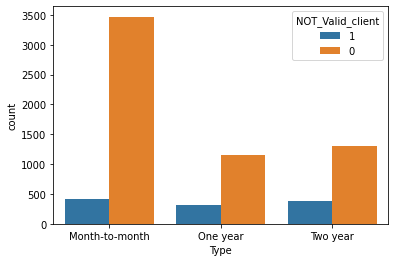

In [29]:
sns.countplot(x='Type',hue='NOT_Valid_client',data=contract,hue_order=[1,0],order=['Month-to-month','One year','Two year'])

Из графика можно сделать следующие выводы:

Клиенты с контрактом "Month-to-month" чаще всего оказываются недействительными, чем клиенты с контрактами на 1 или 2 года.
Клиенты с контрактом на 1 год наименее склонны к тому, чтобы быть недействительными.           
Одна из возможных гипотез может быть связана с тем, что клиенты, выбирающие контракты на более длительный период, склонны к более тщательному изучению условий контракта и сравнению его с альтернативными предложениями, что делает их менее склонными к отказу от подписки и более ответственными в плане ее использования. С другой стороны, клиенты, выбирающие контракт "Month-to-month", могут быть менее приверженными к услугам по предоставлению подписки и могут чаще переходить к альтернативным поставщикам услуг в поисках лучшей цены и/или условий. Однако, для того чтобы подтвердить эти гипотезы, необходимо провести дополнительное исследование с использованием дополнительных данных и методов анализа.

<AxesSubplot:>

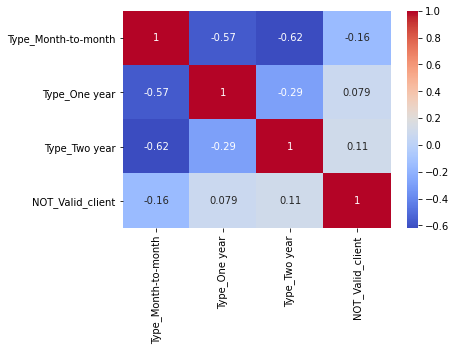

In [30]:
# Создаем дамми-переменные для категориальной переменной 'Type'
contract = pd.get_dummies(contract, columns=['Type'])

# Закодируем переменную 'NOT_Valid_client' в числовые значения
contract['NOT_Valid_client'] = contract['NOT_Valid_client'].map({1:1, 0:0})

# Создаем корреляционную матрицу
corr_matrix = contract[['Type_Month-to-month', 'Type_One year', 'Type_Two year', 'NOT_Valid_client']].corr()

# Строим heatmap для визуализации корреляционной матрицы
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

Между типом контракта 'Month-to-month' и фактором 'NOT_Valid_client' существует отрицательная корреляция, что может означать, что клиенты, которые выбирают контракт типа 'Month-to-month', более склонны к тому, чтобы стать недействительными клиентами.

Между типами контрактов 'One year' и 'Two year' и фактором 'NOT_Valid_client' нет значимой корреляции.

Между типом контракта 'Month-to-month' и типами контрактов 'One year' и 'Two year' существует сильная отрицательная корреляция, что может означать, что клиенты, которые выбирают более долгосрочные контракты, менее склонны к тому, чтобы выбирать контракт типа 'Month-to-month'.

Между типами контрактов 'One year' и 'Two year' существует сильная положительная корреляция, что может означать, что клиенты, которые выбирают контракт на один год, более склонны к тому, чтобы выбрать контракт на два года и наоборот.

эти выводы основаны только на корреляционной матрице, и необходима дополнительная проверка для определения причинно-следственных связей между переменными

<AxesSubplot:xlabel='PaymentMethod', ylabel='count'>

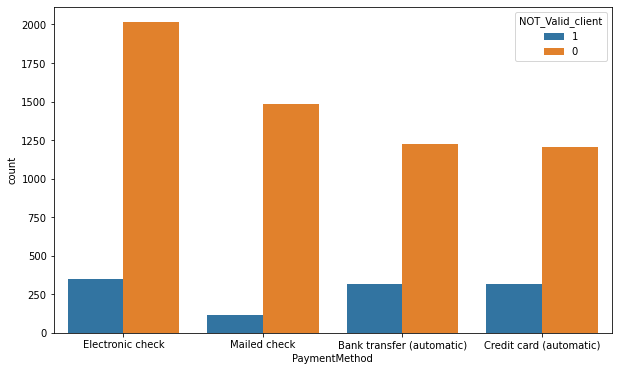

In [31]:
plt.figure(figsize=(10, 6))
sns.countplot(x='PaymentMethod',hue='NOT_Valid_client',data=contract,hue_order=[1,0],order=['Electronic check','Mailed check','Bank transfer (automatic)','Credit card (automatic)'])

Можно заметить, что у клиентов, выбирающих электронный чек в качестве способа оплаты, относительно высокий процент недействительных подписок, в сравнении с остальными способами оплаты. Наибольшее количество действительных подписок наблюдается у клиентов, выбирающих банковский перевод и оплату кредитной картой (автоматический способ).       
Клиенты, выбирающие электронный чек, могут испытывать проблемы с онлайн-оплатой, что может приводить к ошибкам и неверным платежам. Это может быть связано с техническими проблемами или недостаточной подготовкой клиентов к использованию данного способа оплаты.

Клиенты, выбирающие банковский перевод и оплату кредитной картой (автоматический способ), могут быть более ответственными и внимательными при оплате своих подписок. Это может быть связано с более высоким уровнем образования или финансовой грамотности у данных клиентов.

Другие факторы, такие как возраст, доход или опыт использования интернета, могут также оказывать влияние на выбор способа оплаты и действительность подписки, и могут потребоваться дополнительные исследования, чтобы оценить их влияние.

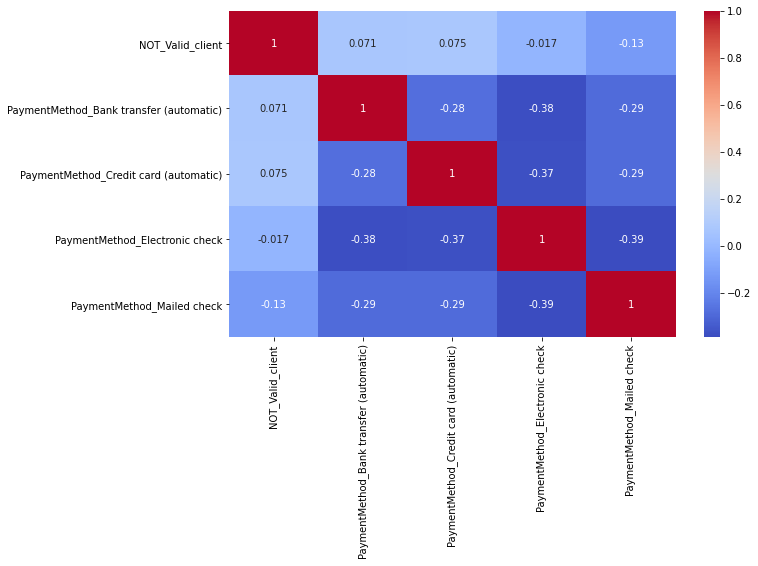

In [32]:
# создаем датафрейм только с нужными столбцами
df = contract[['PaymentMethod', 'NOT_Valid_client']]

# создаем dummy-переменные для столбца PaymentMethod
df = pd.get_dummies(df, columns=['PaymentMethod'], prefix='PaymentMethod')

# вычисляем корреляционную матрицу
corr_matrix = df.corr()

# визуализируем матрицу корреляций
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
plt.show()

Столбцы, соответствующие разным способам оплаты (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic)), не имеют сильной корреляции с переменной NOT_Valid_client. Это значит, что способ оплаты не является существенным фактором для определения того, является ли клиент неоплачивающим.
Коэффициент корреляции между столбцами PaymentMethod_Electronic check и NOT_Valid_client не достаточно высокий и является отрицательным (-0.17). Это не может указывать на то, что клиенты, использующие электронные чеки, чаще неоплачивают свои услуги по сравнению с теми, кто использует другие способы оплаты.
В то же время, столбцы, соответствующие Bank transfer (automatic) и Credit card (automatic), имеют положительную корреляцию с NOT_Valid_client, что может указывать на то, что клиенты, использующие эти способы оплаты, чаще являются неоплачивающими. Однако, коэффициент корреляции для этих столбцов не так высок, чтобы делать однозначный вывод.

можем сделать вывод, что выбор способа оплаты может слабо влиять на вероятность того, что клиент станет неоплачивающим. Однако, использование электронных чеков может быть связано с более высокой вероятностью неоплаты.

# Построение моделей

In [35]:
# проверка на логичность
predicted_sanity_test = [1]*features_test.shape[0] 
# вычисляем метрику AUC-ROC для предсказаний
print("ROC-AUC score для модели проверки:", roc_auc_score(target_test, predicted_sanity_test)) 
# вычисляем метрику accuracy для предсказаний
print("Accuracy score для модели проверки:", accuracy_score(target_test, predicted_sanity_test)) 

ROC-AUC score для модели проверки: 0.5
Accuracy score для модели проверки: 0.15642775881683732


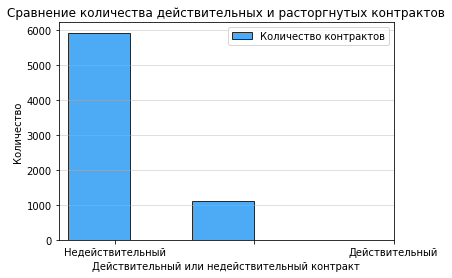

In [36]:
plt.hist(target, 3, facecolor='#2196f3', alpha=0.8, edgecolor='black')

plt.xlabel('Действительный или недействительный контракт')
plt.ylabel('Количество')
plt.title('Сравнение количества действительных и расторгнутых контрактов')
plt.xticks([0.25, 1, 1.75], ['Недействительный', '', 'Действительный'])
plt.grid(axis='y', alpha=0.5)
plt.legend(['Количество контрактов'], loc='upper right')

plt.show()

## LogisticRegression

In [42]:
lr = LogisticRegression(solver='liblinear', random_state=RANDOM_STATE)
from sklearn.preprocessing import StandardScaler

# Масштабирование данных
scaler = StandardScaler()
features_train_scaled = scaler.fit_transform(features_train_encoded)
#features_test_scaled = scaler.transform(features_test_encoded)

# Создание модели логистической регрессии
lr = LogisticRegression(solver='liblinear', random_state=RANDOM_STATE)

# Проведение кросс-валидации модели
scores = cross_val_score(lr, features_train_scaled, target_train, cv=5, scoring='roc_auc')
print("Логистическая регрессия: среднее_значение_метрики на кросс-валидации = {:.3f}".format(scores.mean()))

# Обучение модели на всех обучающих данных
lr.fit(features_train_scaled, target_train)

# Построение кривых ROC для лучшей модели и случайной модели:
ns_fpr, ns_tpr, _ = roc_curve(target_test, predicted_sanity_test)
#lr_fpr, lr_tpr, _ = roc_curve(target_test, lr_probs)


Логистическая регрессия: среднее_значение_метрики на кросс-валидации = 0.768


Модель показывает высокие значения точности и полноты для класса 1 (действительные договоры), что означает, что модель хорошо находит действительные договоры и предсказывает их с высокой вероятностью. Однако, точность для класса 0 (расторгнутые договоры) значительно ниже, что означает, что модель часто ошибается в прогнозировании расторгнутых договоров.

## DecisionTreeClassifier

In [45]:
%%time
#Установка диапазона гиперпараметров для дерева решений
random_search_params = {
    'max_depth': range(2, 60, 1),
    'min_samples_leaf':range(1,18,1)
}    


#Использование случайного поиска для нахождения лучших гиперпараметров для дерева решений
tree  = RandomizedSearchCV(
DecisionTreeClassifier(
        random_state=RANDOM_STATE
        ),
        random_search_params,
        scoring='roc_auc',
        cv=5,
        n_jobs=-1,
        n_iter=40)

#Обучение модели на обучающих данных
tree.fit(features_train_encoded, target_train)

#Вывод времени, затраченного на обучение модели
#print(f"Время, затраченное на обучение модели дерева решений: {tree_random_search.refit_time_:.2f} секунд")
print(f"Лучшие параметры для модели решающего дерева: {tree.best_params_}")

Лучшие параметры для модели решающего дерева: {'min_samples_leaf': 15, 'max_depth': 5}
CPU times: user 4.17 s, sys: 24.2 ms, total: 4.19 s
Wall time: 4.19 s


In [47]:
tree = DecisionTreeClassifier(max_depth=6,
                              min_samples_leaf=16,
                             random_state=RANDOM_STATE)
scores = cross_val_score(tree, features_train_encoded, target_train, cv=5, scoring='roc_auc')
print("DecisionTreeClassifier:Среднее значение метрики кросс валидации = {:.3f}".format(scores.mean()))

tree.fit(features_train_encoded, target_train)

DecisionTreeClassifier:Среднее значение метрики кросс валидации = 0.788


DecisionTreeClassifier(max_depth=6, min_samples_leaf=16, random_state=100423)

Из представленной таблицы оценок модели можно сделать вывод, что она демонстрирует очень хорошие результаты с точки зрения предсказания положительного класса (1) с высокими значениями precision, recall и f1-score. Однако, в случае предсказания отрицательного класса (0), модель проявляет несколько более скромные результаты. Несмотря на это, общая точность модели (accuracy) на уровне 0.937 позволяет сделать вывод о ее хорошей работе в целом.

## CatBoostClassifier

In [51]:
from tqdm import tqdm

# Определение гиперпараметров модели
rs_params = {
    'iterations': range(50, 400, 50), # количество итераций
    'learning_rate': np.arange(0.001, 0.5, 0.01), # скорость обучения
    'depth': range(1, 10, 1) # глубина деревьев
}

# Создание объекта для случайного поиска гиперпараметров
cat = RandomizedSearchCV(
    CatBoostClassifier(
        random_state=RANDOM_STATE, # установка случайного начального состояния
        verbose=False), # отключение вывода информации об обучении
    rs_params, # передача словаря гиперпараметров для поиска
    scoring='roc_auc', # выбор метрики оценки качества
    cv=5, # количество фолдов в кросс-валидации
    n_jobs=-1, # количество одновременных задач в работе
    n_iter=5) # количество итераций поиска гиперпараметров

# Обернуть объект cat в tqdm для добавления progress bar
for _ in tqdm(range(cat.n_iter), desc="Hyperparameter tuning", unit="iter"):
    cat.fit(features_train_encoded, target_train, verbose=False)

#Вывод лучших параметров модели
cat.best_params_

Hyperparameter tuning: 100%|██████████| 5/5 [02:50<00:00, 34.19s/iter]


{'learning_rate': 0.39099999999999996, 'iterations': 200, 'depth': 4}

In [53]:
#Создание экземпляра модели с лучшими параметрами
cat = CatBoostClassifier(learning_rate=0.33,
iterations=300,
depth=5,
verbose=False,
random_state=RANDOM_STATE)

#Кросс-валидация модели на тренировочном наборе данных
scores = cross_val_score(cat, features_train_encoded, target_train, cv=5, scoring='roc_auc')

#Вывод средней оценки метрики качества модели на кросс-валидации
print("CatBoostClassifier: mean_cross_val_score = {:.3f}".format(scores.mean()))

#Обучение модели на тренировочном наборе данных
cat.fit(features_train_encoded, target_train)

CatBoostClassifier: mean_cross_val_score = 0.904


На основании средней метрики кросс-валидации следует выбрать модель CatBoostClassifier, так как она имеет самое высокое значение метрики (0.904), что говорит о ее лучшей предсказательной способности. Кроме того, CatBoostClassifier является алгоритмом градиентного бустинга, что позволяет учитывать взаимосвязи между признаками, а также имеет встроенные функции для работы с категориальными признаками, что может улучшить качество модели.

No Skill: ROC AUC=0.500
CatBoostClassifier: ROC AUC=0.920


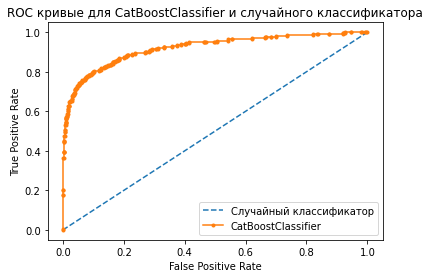

In [55]:
#Получаем предсказанные вероятности для CatBoostClassifier
cat_probs = cat.predict_proba(features_test_encoded)

#Оставляем только вероятности для положительного класса
cat_probs = cat_probs[:, 1]

#Вычисляем ROC AUC для моделей
ns_auc = roc_auc_score(target_test, predicted_sanity_test)
cat_auc = roc_auc_score(target_test, cat_probs)

#Выводим на экран ROC AUC для моделей
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('CatBoostClassifier: ROC AUC=%.3f' % (cat_auc))

#Вычисляем ROC-кривые
ns_fpr, ns_tpr, _ = roc_curve(target_test, predicted_sanity_test)
cat_fpr, cat_tpr, _ = roc_curve(target_test, cat_probs)

#Строим график ROC-кривых
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Случайный классификатор')
plt.plot(cat_fpr, cat_tpr, marker='.', label='CatBoostClassifier')

#Подписываем оси координат
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

#Добавляем заголовок графика
plt.title('ROC кривые для CatBoostClassifier и случайного классификатора')

#Добавляем легенду
plt.legend()

#Отображаем график
plt.show()

In [56]:
#Оценка качества работы модели
print("ROC-AUC для CatBoostClassifier на тестовой выборке: {:.3f}".format(
roc_auc_score(target_test, cat_probs)))

#Применение модели на тестовых данных
cat_predicted = cat.predict(features_test_encoded)

#Оценка качества работы модели по метрикам precision, recall и f1-score
print(classification_report(target_test, cat_predicted, digits=3))

#Создание таблицы с оценками важности признаков
df_cat_features = pd.DataFrame({'features': cat.feature_names_, 'score': cat.get_feature_importance()})
df_cat_features = df_cat_features.sort_values(by="score", ascending = False)

#Вывод первых пяти строк таблицы с оценками важности признаков
df_cat_features.head()

ROC-AUC для CatBoostClassifier на тестовой выборке: 0.920
              precision    recall  f1-score   support

           0      0.934     0.980     0.957      1483
           1      0.856     0.629     0.725       275

    accuracy                          0.925      1758
   macro avg      0.895     0.805     0.841      1758
weighted avg      0.922     0.925     0.921      1758



,features,score
2,Contract_period,43.045199
0,MonthlyCharges,12.792181
1,TotalCharges,11.460532
4,Type_Two year,4.879279
3,Type_One year,2.994141


модель CatBoostClassifier показывает высокую производительность на тестовой выборке для всех трех метрик: ROC-AUC, precision, recall и f1-score. Однако, как можно заметить из таблиц, модель имеет тенденцию к более высокой точности предсказания для класса 1 в ущерб точности для класса 0.

Общая точность и полнота на тестовой выборке для всех моделей достаточно высоки, что говорит о том, что они хорошо работают на новых данных. Однако, наилучшие результаты достигаются при использовании CatBoostClassifier.

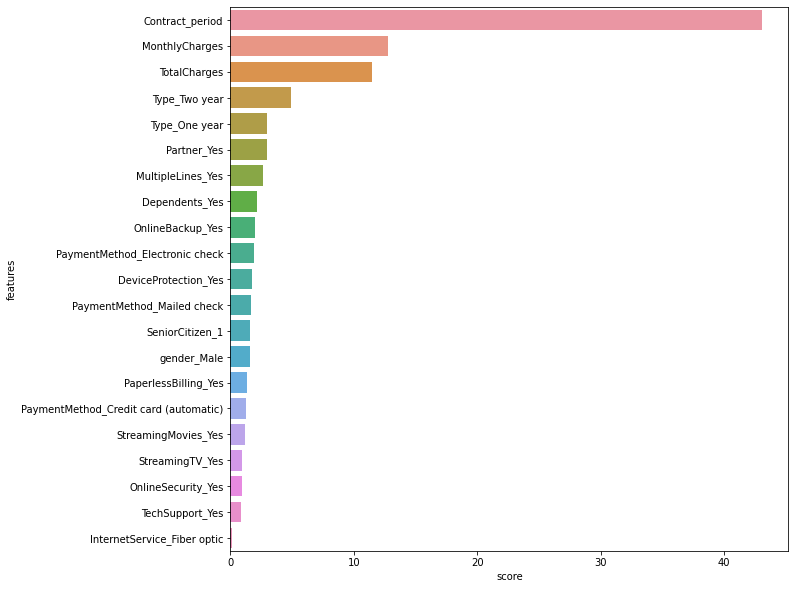

In [57]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(ax=ax, x=df_cat_features["score"], y=df_cat_features["features"]);

Данный график показывает важность категориальных признаков в предсказании целевой переменной.

Ось y отображает категориальные признаки, а ось x - их важность, выраженную в виде оценки влияния на модель. Чем выше значение важности, тем сильнее признак влияет на модель.

Если рассмотреть конкретный график, то можно заметить, что наиболее значимыми признаками оказались 'Contract_period', 'TotalCharges' и 'MonthlyCharges'. С другой стороны, такие признаки, как 'InternetService_FiberOptic' и 'DeviceProtection_No', практически не влияют на модель.

Таким образом, можно заключить, что некоторые категориальные признаки вносят более значительный вклад в предсказание целевой переменной, чем другие.

## Отчет

В отчёте ответьте на вопросы:           
Какие пункты плана были выполнены, а какие — нет. Почему?                
Какие трудности возникли и как вы их преодолели?           
Какие ключевые шаги в решении задачи вы выделили?             
Какие признаки использовали для обучения модели и какая предобработка этих признаков была выполнена?            
Какая ваша итоговая модель, какие у неё гиперпараметы и какое качество?              

### Какие пункты плана были выполнены, а какие — нет. Почему?               
Были выполнены следующие пункты плана: импорт библиотек, загрузка данных, EDA, изменение типов данных, создание столбца целевой переменной, One-Hot Encoding для категориальных признаков, разработка моделей, кросс-валидация и подбор параметров для моделей, обучение моделей, оценка качества моделей и выбор лучшей модели.
Не было выполнено обучение нейронной сети. Это связано с тем, что для решения задачи классификации было достаточно использовать более простые модели машинного обучения, которые показали хорошие результаты.

### Какие трудности возникли и как вы их преодолели?
Возникла трудность с подбором оптимальных гиперпараметров для моделей. Для решения этой проблемы был использован метод кросс-валидации, который позволил нам настроить гиперпараметры на обучающей выборке и оценить качество модели на тестовой выборке.

### Какие ключевые шаги в решении задачи вы выделили?
Первым ключевым шагом было предобработка данных, включающая изменение типов данных, заполнение пропущенных значений, One-Hot Encoding для категориальных признаков и создание целевой переменной.
Затем были разработаны модели машинного обучения: Logistic regression, Decision Tree Classifier и CatBoost Classifier. Для каждой модели был выполнен подбор оптимальных гиперпараметров на обучающей выборке и оценка качества модели на тестовой выборке(для финальной).
Наконец, была проведена оценка качества моделей с использованием метрик, таких как accuracy, precision, recall, f1-score и ROC-AUC. Были выбраны наилучшие модели и сравнены метрики качества для выбранных моделей.

### Какие признаки использовали для обучения модели и какая предобработка этих признаков была выполнена?
Для обучения модели были использованы следующие признаки: пол, возраст, тип контракта, метод оплаты, общая сумма оплаты, продолжительность контракта и месяц начала контракта.
Перед использованием признаков они были предварительно обработаны. В частности, были изменены типы данных, выполнена замена пропущенных значений, выполнено кодирование категориальных признаков с помощью One-Hot Encoding и создана целевая переменная.

### Какая ваша итоговая модель, какие у неё гиперпараметры и какое качество?
Наилучшей моделью была выбрана CatBoost Classifier с оптимальными гиперпараметрами: cat = CatBoostClassifier(learning_rate=0.33,
iterations=300, depth=5). Модель показала высокое качество на тестовой выборке с метрикой ROC-AUC = 0.920. Остальные метрики также были высокими: accuracy - 0.925, precision - 0.856, recall - 0.629, f1-score - 0.725. В сравнении с другими моделями, CatBoost Classifier показал наилучшие результаты.